In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [42]:
df = pd.read_csv(r"D:\Codes\Notebook\Algorithmic_Trading\forecasting\PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [43]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [44]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

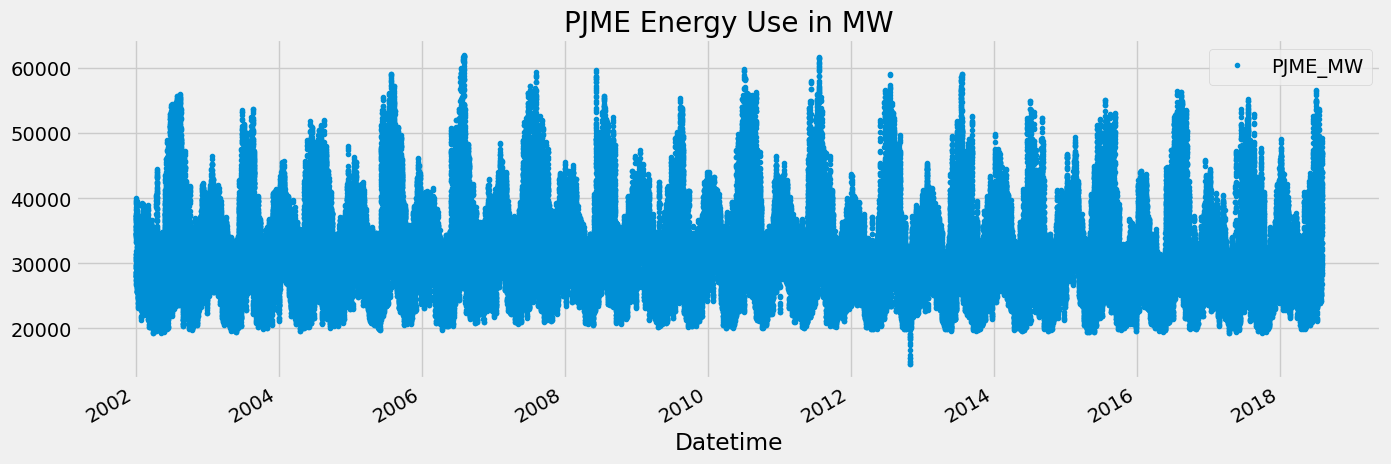

In [45]:
df.plot(style='.', 
        figsize=(15,5), 
        color = color_pal[0], 
        title='PJME Energy Use in MW')

## Train Test Split

In [46]:
train = df.loc[df.index < '01-01-2015']  
test = df.loc[df.index >= '01-01-2015']  

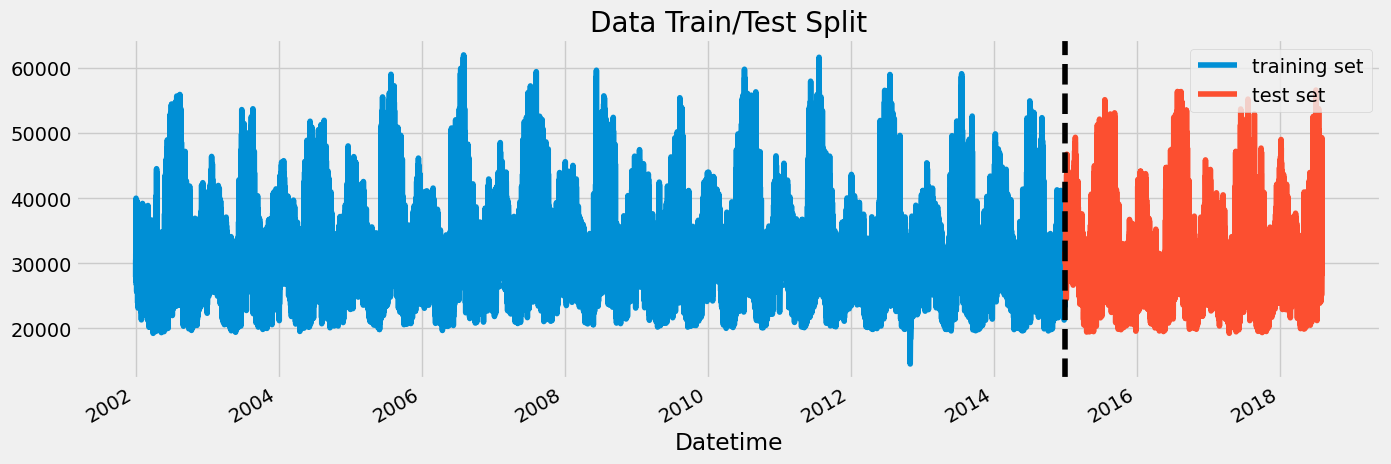

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'training set', title='Data Train/Test Split')
test.plot(ax=ax, label = 'test set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['training set', 'test set'])
plt.show()

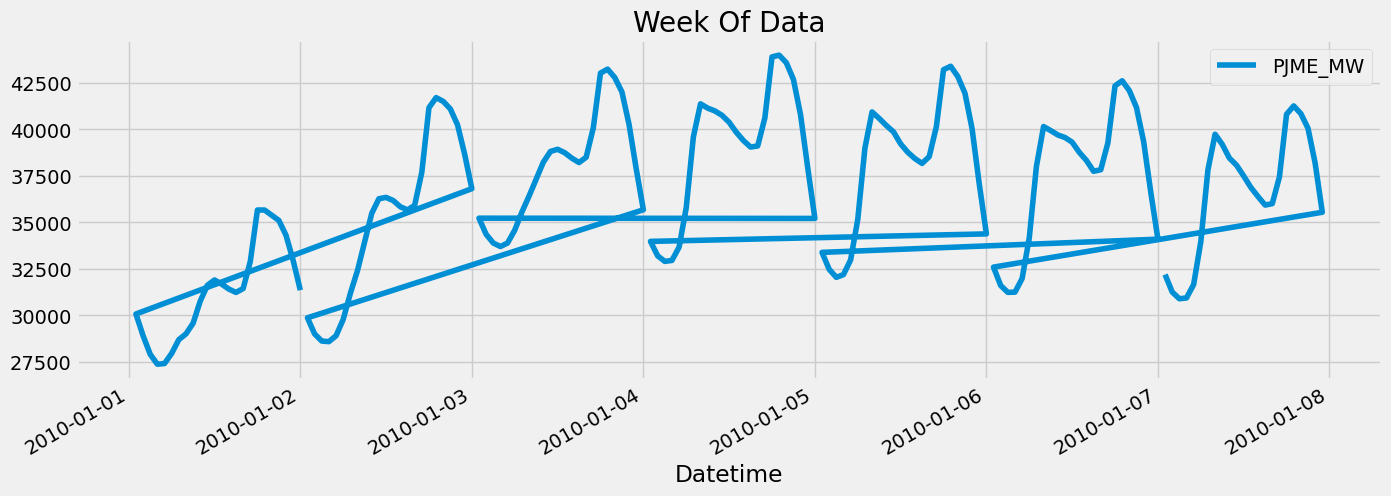

In [48]:
# How a single week of data looks like

df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(
    figsize=(15, 5), title='Week Of Data'
)
plt.show()


## Feature Creation

In [56]:

def create_features(df):
    """
        Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365


In [50]:
df.tail()

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2


## Visualize our feature / Target Relationship

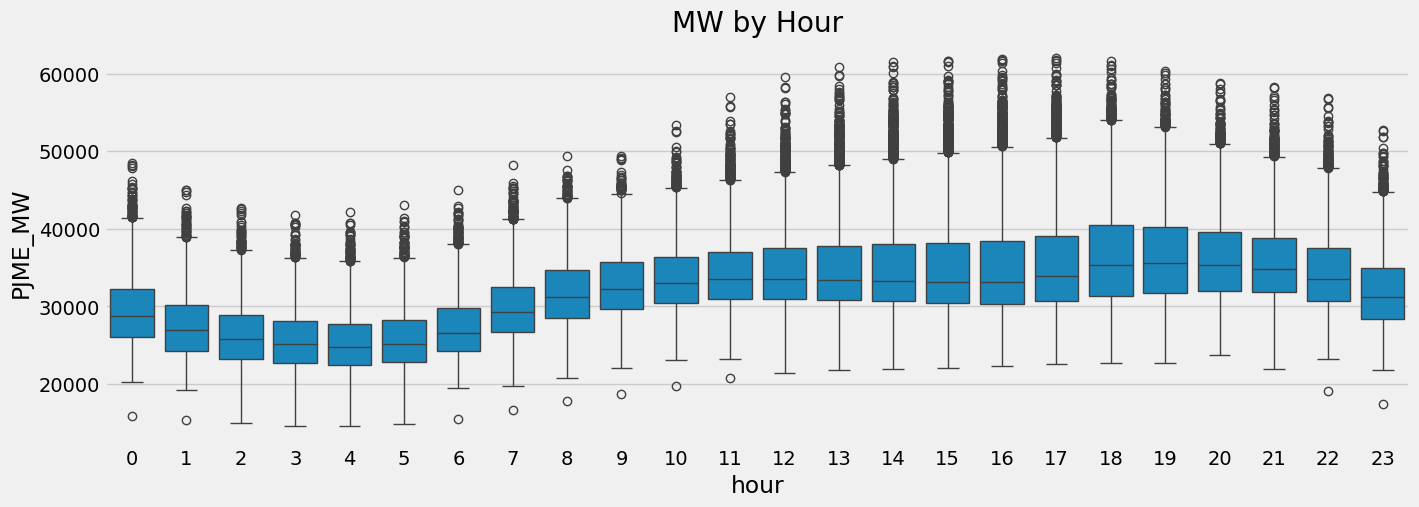

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_7320\1334290991.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y = 'PJME_MW', palette='Blues')


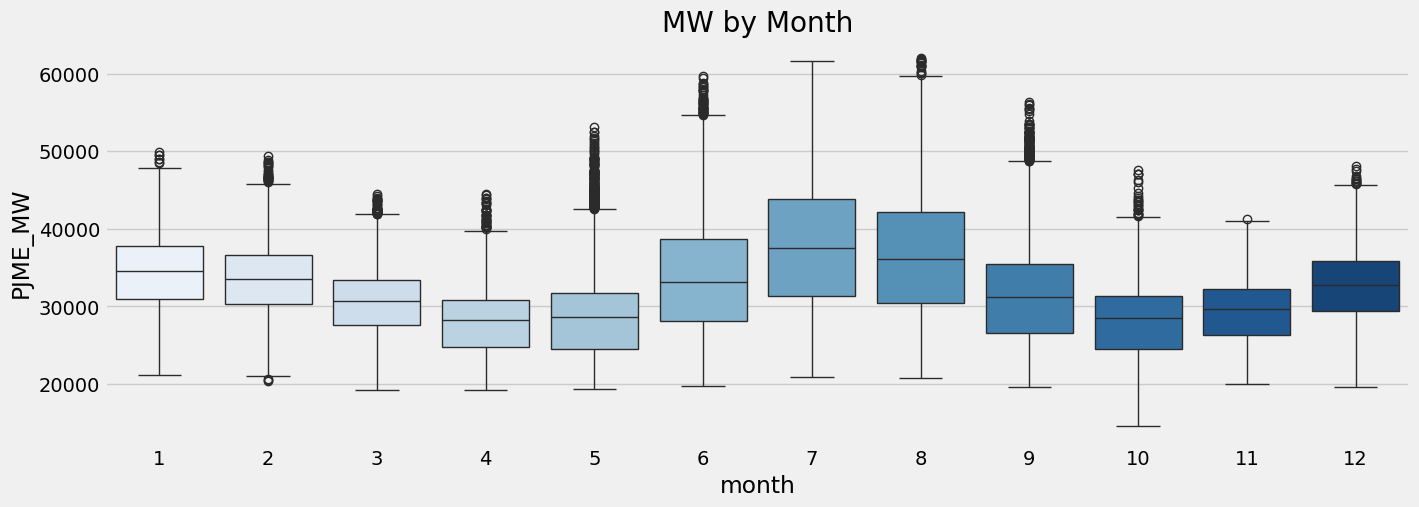

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y = 'PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [61]:
train = create_features(train)
test = create_features(test)

FEATURES = [ 'hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [60]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear'],
      dtype='object')

In [62]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Create our Model

In [66]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds = 50, # model trainnig to stop earaly if the test set does not improve after 50 trees
                       learning_rate=0.001  #lowered the learning rate to avoid overfitting
                       )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test,y_test)],
        verbose=100  # create a validation scores after every 100 tree that are built
        )

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.54145
[100]	validation_0-rmse:6026.49339	validation_1-rmse:6131.08053
[200]	validation_0-rmse:5654.75124	validation_1-rmse:5796.65490
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.59274
[400]	validation_0-rmse:5039.56899	validation_1-rmse:5253.21086
[500]	validation_0-rmse:4788.58887	validation_1-rmse:5034.74880
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.76655
[700]	validation_0-rmse:4372.19812	validation_1-rmse:4687.11295
[800]	validation_0-rmse:4202.53312	validation_1-rmse:4547.57144
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.00726
[999]	validation_0-rmse:3929.32983	validation_1-rmse:4325.35302


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## FEATURE IMPORTANCE

In [68]:
## Important values based on how much each feature was used in each of the trees built by the model

fi = pd.DataFrame(data = reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi

,importance
hour,0.363428
dayofweek,0.166284
month,0.315336
quarter,0.000000
year,0.013799
dayofyear,0.141154


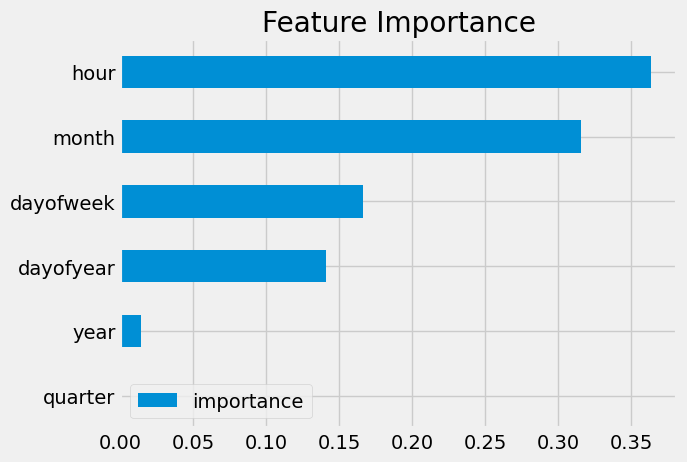

In [69]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on the Test

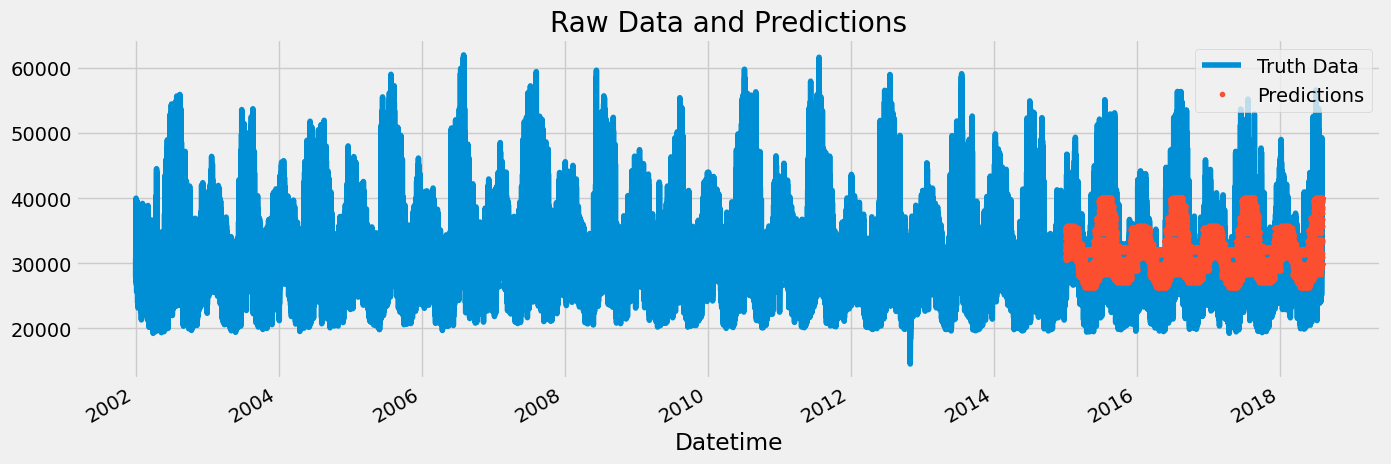

In [82]:
test['predictions'] = reg.predict(X_test)
df = df.merge(test['predictions'], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

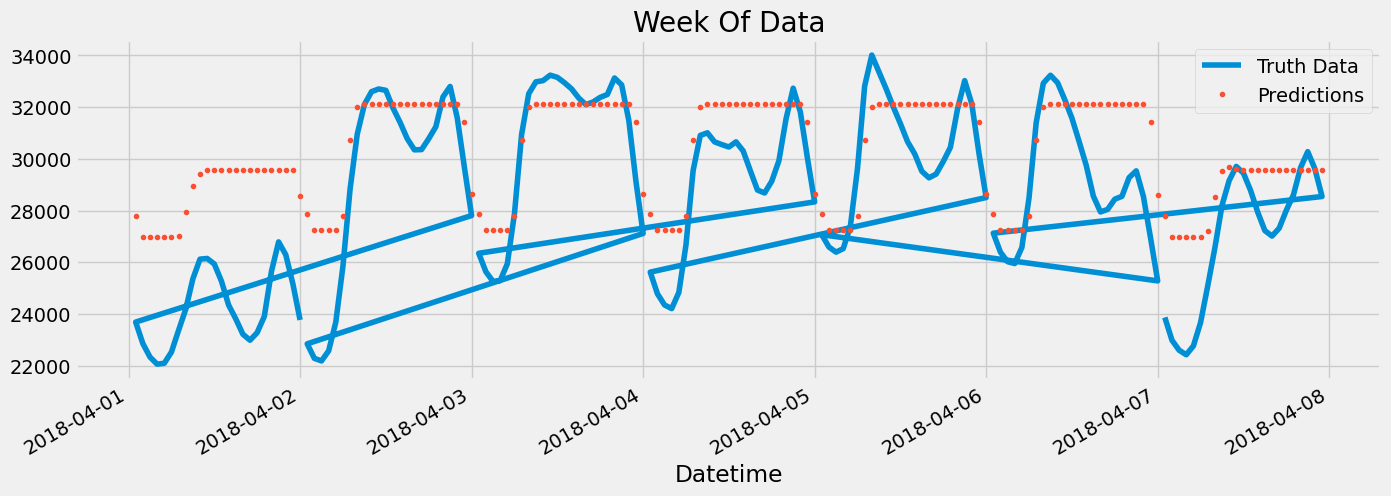

In [84]:
# How a single week of data looks like

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions']\
    .plot(style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()


In [86]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f"RMSE on the test set is: {score:0.2f}")

RMSE on the test set is: 4325.35


## Calculate Error
- Look at the worst and best predicted days

In [88]:
#Error
test['error'] = np.abs(test[TARGET] - test['predictions'])

In [89]:
#adding dates for it to have its own values
test['date'] = test.index.date

In [92]:
#Average error for each day predicted
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    12092.418620
2016-08-14    11407.225098
2018-01-06    11024.924316
2015-02-20    10791.006348
2016-09-09    10337.963704
Name: error, dtype: float64

In [93]:
#Average error for each day predicted
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-29    764.857666
2016-12-30    783.728760
2017-11-18    849.959310
2017-03-18    870.751546
2018-04-03    880.189860
Name: error, dtype: float64